# Annotation by clicking single cells in the Napari UI
In this tutorial, we will explore the process of annotating single cells within the Napari User Interface (UI), which is an essential step to leverage machine learning algorithms for further analysis, such as mitosis detection.

In [1]:
# import some common libraries
import os
import glob
import os.path
import numpy as np
import json, random, cv2
from cellpose import models
from cellpose.io import imread
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from skimage import measure
from PIL import Image, ImageSequence

# from livecellx import segment
from livecellx import core
from livecellx.core import datasets
from livecellx.core import SingleCellTrajectory, SingleCellStatic
from livecellx.core.datasets import LiveCellImageDataset, SingleImageDataset
from livecellx.sample_data import tutorial_three_image_sys

In [2]:
import napari
napari.__version__  # should be 0.4.10 or greater

'0.4.18'

## Loading data
Before the annotation process, it's essential to load the data - either from pre-prepared masks(`prep_scs_from_mask_dataset`) or a specific JSON file containing single cell information. We showcase two examples: how to load data from a particular dataset named EBSS data, 24 hours and how to load a sample tutorial 3-image dataset. 

In the first example (EBSS data), we define the paths for our dataset and mask dataset. We then create a LiveCellImageDataset object for the mask data and a dictionary time2url to map indices to the file paths of the DIC images. We again use LiveCellImageDataset to hold our DIC dataset. 

### EBSS data, 24 hours

In [3]:
# dataset_dir_path = Path(
#     "../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/XY16/"
# )

# mask_dataset_path = Path("../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/out/XY16/seg")

# mask_dataset = LiveCellImageDataset(mask_dataset_path, ext="png")
# time2url = sorted(glob.glob(str((Path(dataset_dir_path) / Path("*_DIC.tif")))))
# time2url = {i: path for i, path in enumerate(time2url)}
# dic_dataset = LiveCellImageDataset(time2url=time2url, ext="tif")

### Loading sample tutorial 3-image data
In the second example, we call tutorial_three_image_sys to get the DIC and mask datasets. We then use prep_scs_from_mask_dataset to prepare the single cell data.

In [4]:
from livecellx.core.io_sc import prep_scs_from_mask_dataset

dic_dataset, mask_dataset = tutorial_three_image_sys()
single_cells = prep_scs_from_mask_dataset(mask_dataset, dic_dataset)

|-----> Downloading data to datasets\test_data_STAV-A549.zip
|-----> Data already exists at datasets\test_data_STAV-A549.zip
|-----> Extracting data to datasets
3 png img file paths loaded;
3 tif img file paths loaded;


100%|██████████| 3/3 [00:08<00:00,  2.95s/it]


### Loading your own dataset
The last commented line is a placeholder for loading your own dataset using LiveCellImageDataset.

In [5]:
# dic_dataset = LiveCellImageDataset(...)

**Skip if you do not plan to apply CSN**   
load CSN model if you would like to use it to correct segmentation

In [6]:
# from livecellx.core.sc_seg_operator import ScSegOperator, create_sc_seg_napari_ui

# replace the path below with your downdloaded CSN checkpoint path
# ckpt_path = r"./notebook_results/csn_models/model_v11_epoch=3282-test_loss=2.3688.ckpt"
# ScSegOperator.load_default_csn_model(path=ckpt_path, cuda=True);

## Annotating by clicking single cells in Napari
Napari provides an intuitive interface that allows you to manually segment and annotate cells within images. In this part, we will delve into the process of using the Napari UI for single-cell annotation.

In [7]:
from livecellx.core.sct_operator import create_scs_edit_viewer, SctOperator, create_scs_edit_viewer_by_interval, _get_viewer_sct_operator
from livecellx.core.single_cell import create_sctc_from_scs, filter_sctc_by_time_span


### Manual segmentation and annotation
You may or may not have segmentation ready. If you do not have segmentation masks, you may do annotation manually by starting with an empty list of single cell objects. All you need to do is to load an LiveCellImageDataset object.

### Setting up the annotation interface
The function `create_scs_edit_viewer_by_interval` facilitates the loading of shapes within a specified time window, ranging from t to t + interval. During the annotation process, you can:

Press `n` to move the window forward.
Press `b` to move the window backward.
Press `m` to load from your current step slice.

In [8]:
# sct_operator = create_scs_edit_viewer(single_cells, img_dataset = dic_dataset)
span_interval = 10
# For pre-segmented data:
# viewer = create_scs_edit_viewer_by_interval(single_cells, img_dataset=dic_dataset, span_interval = 10, viewer = None)

# For manual segmentation (when no segmentation masks are available):
viewer = create_scs_edit_viewer_by_interval([], img_dataset=dic_dataset, span_interval = 10, viewer = None)

|-----> A new SCTC object with size 0 is created by subsetting the original sctc with time span (0, 10)


c:\Users\13290\AppData\Local\Programs\Python\Python39\lib\site-packages\napari\utils\colormaps\standardize_color.py:200: UserWarning: Given color input is empty. Converting input to a white color array.
  warnings.warn(


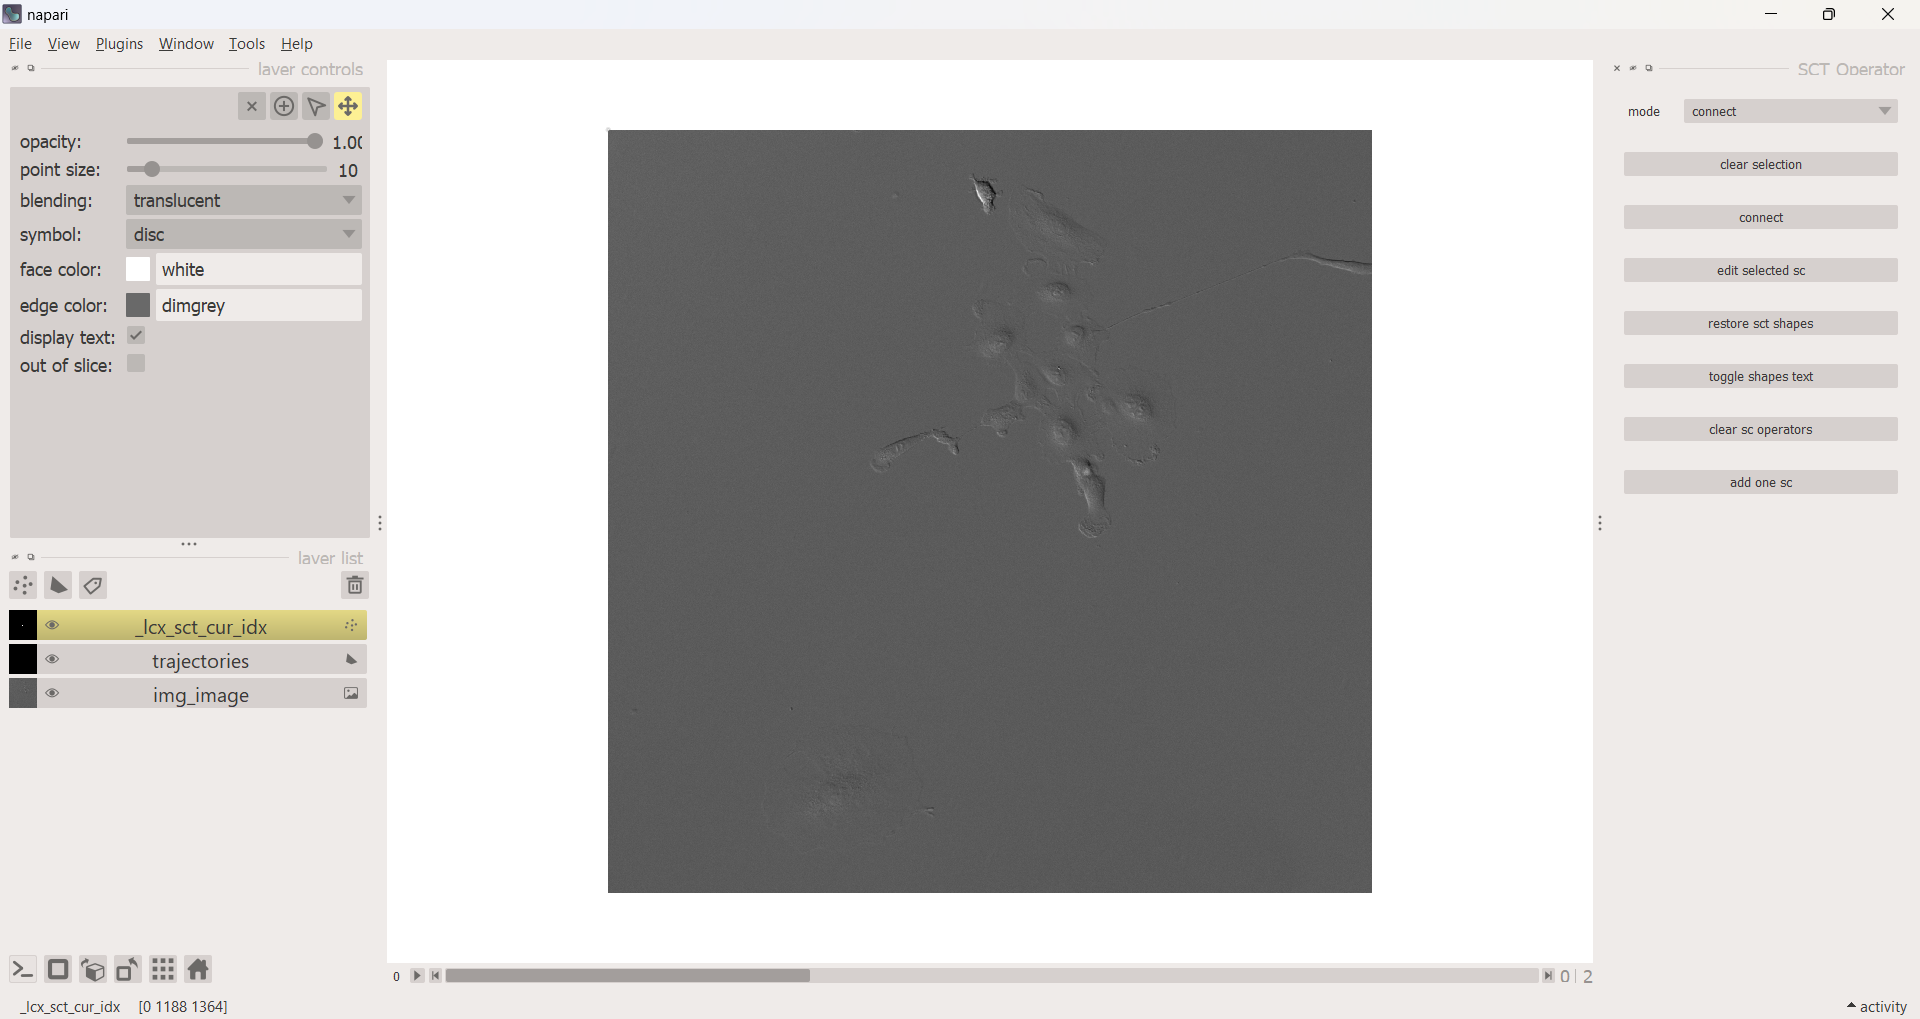

In [ ]:
Run all stop here!

### Validating the Annotations
After manual annotation, it's vital to ensure that your annotations are saved correctly and can be accessed programmatically. Here, we're retrieving the Single Cell Trajectory (SCT) operator from the viewer, which contains all the annotation information.

In [10]:
sct_operator = _get_viewer_sct_operator(viewer)

If you manually annotate, you shall add mask first. Once you finish drawing mask, you need to save it. You finnally click `clear sc operator` on SCT Operator panel: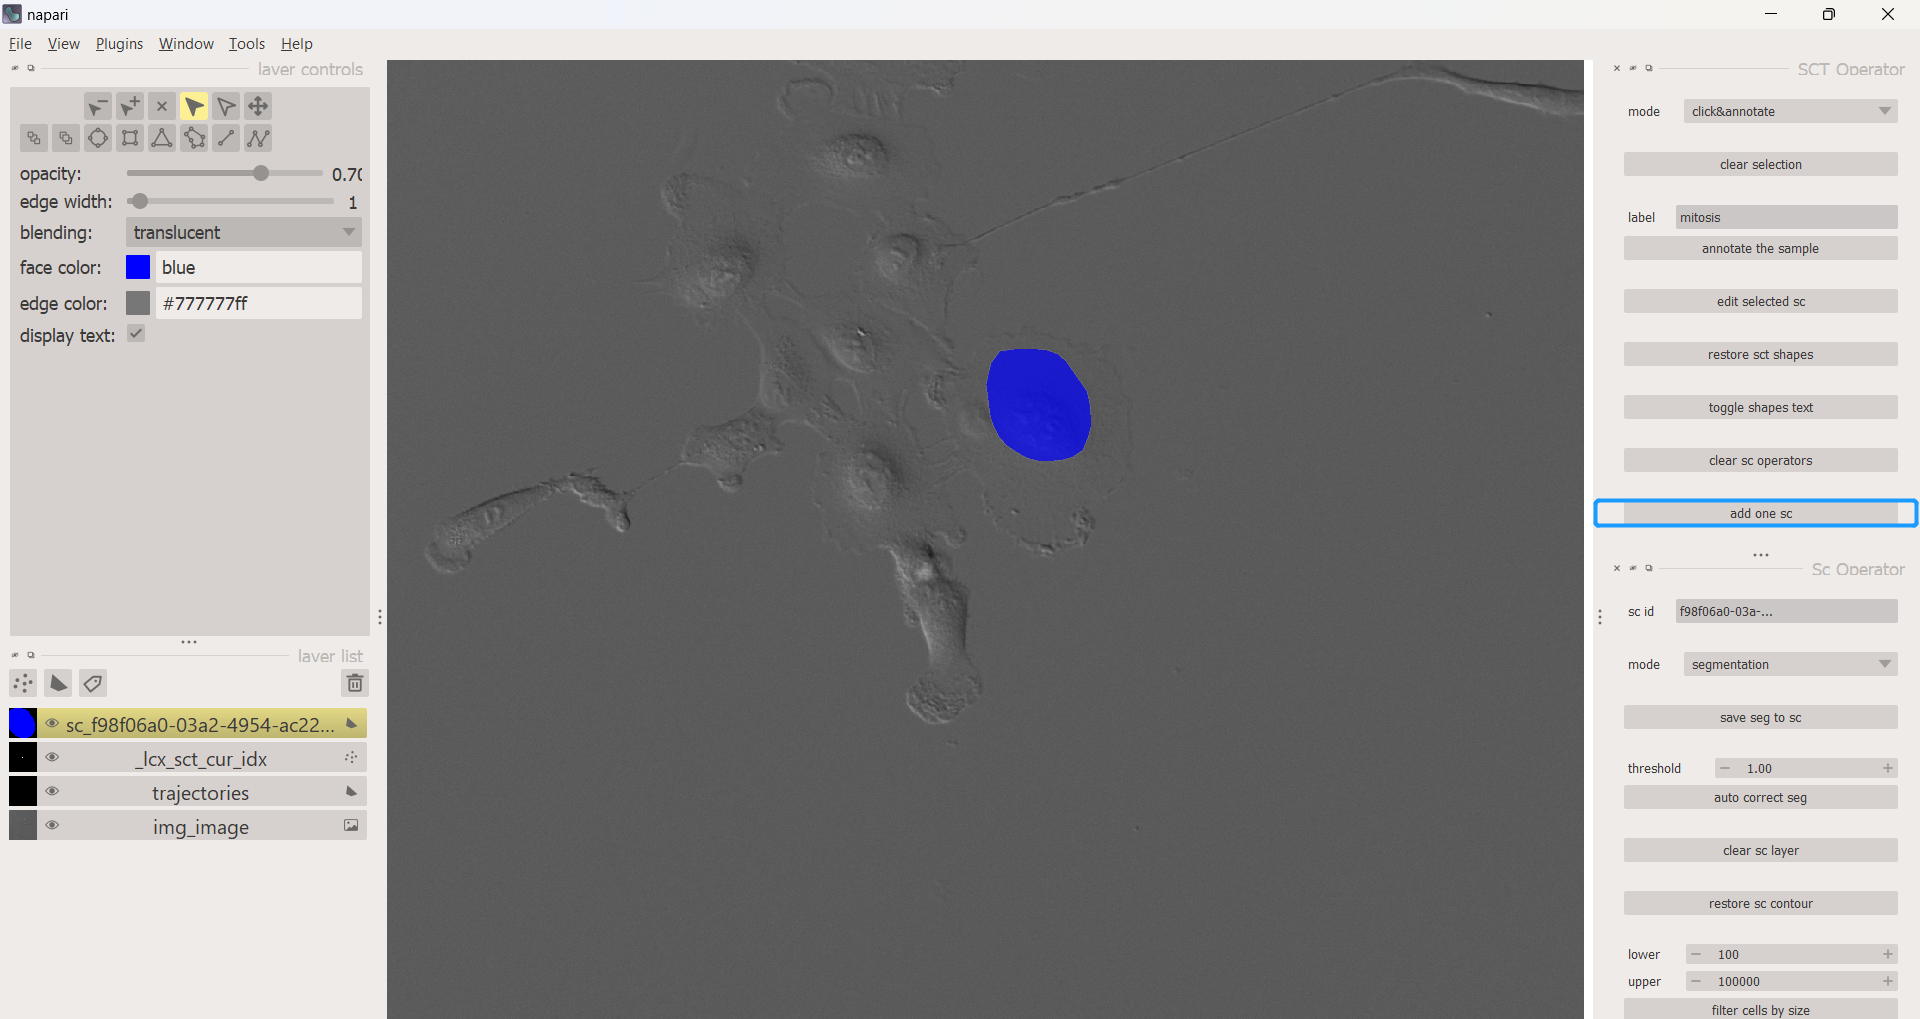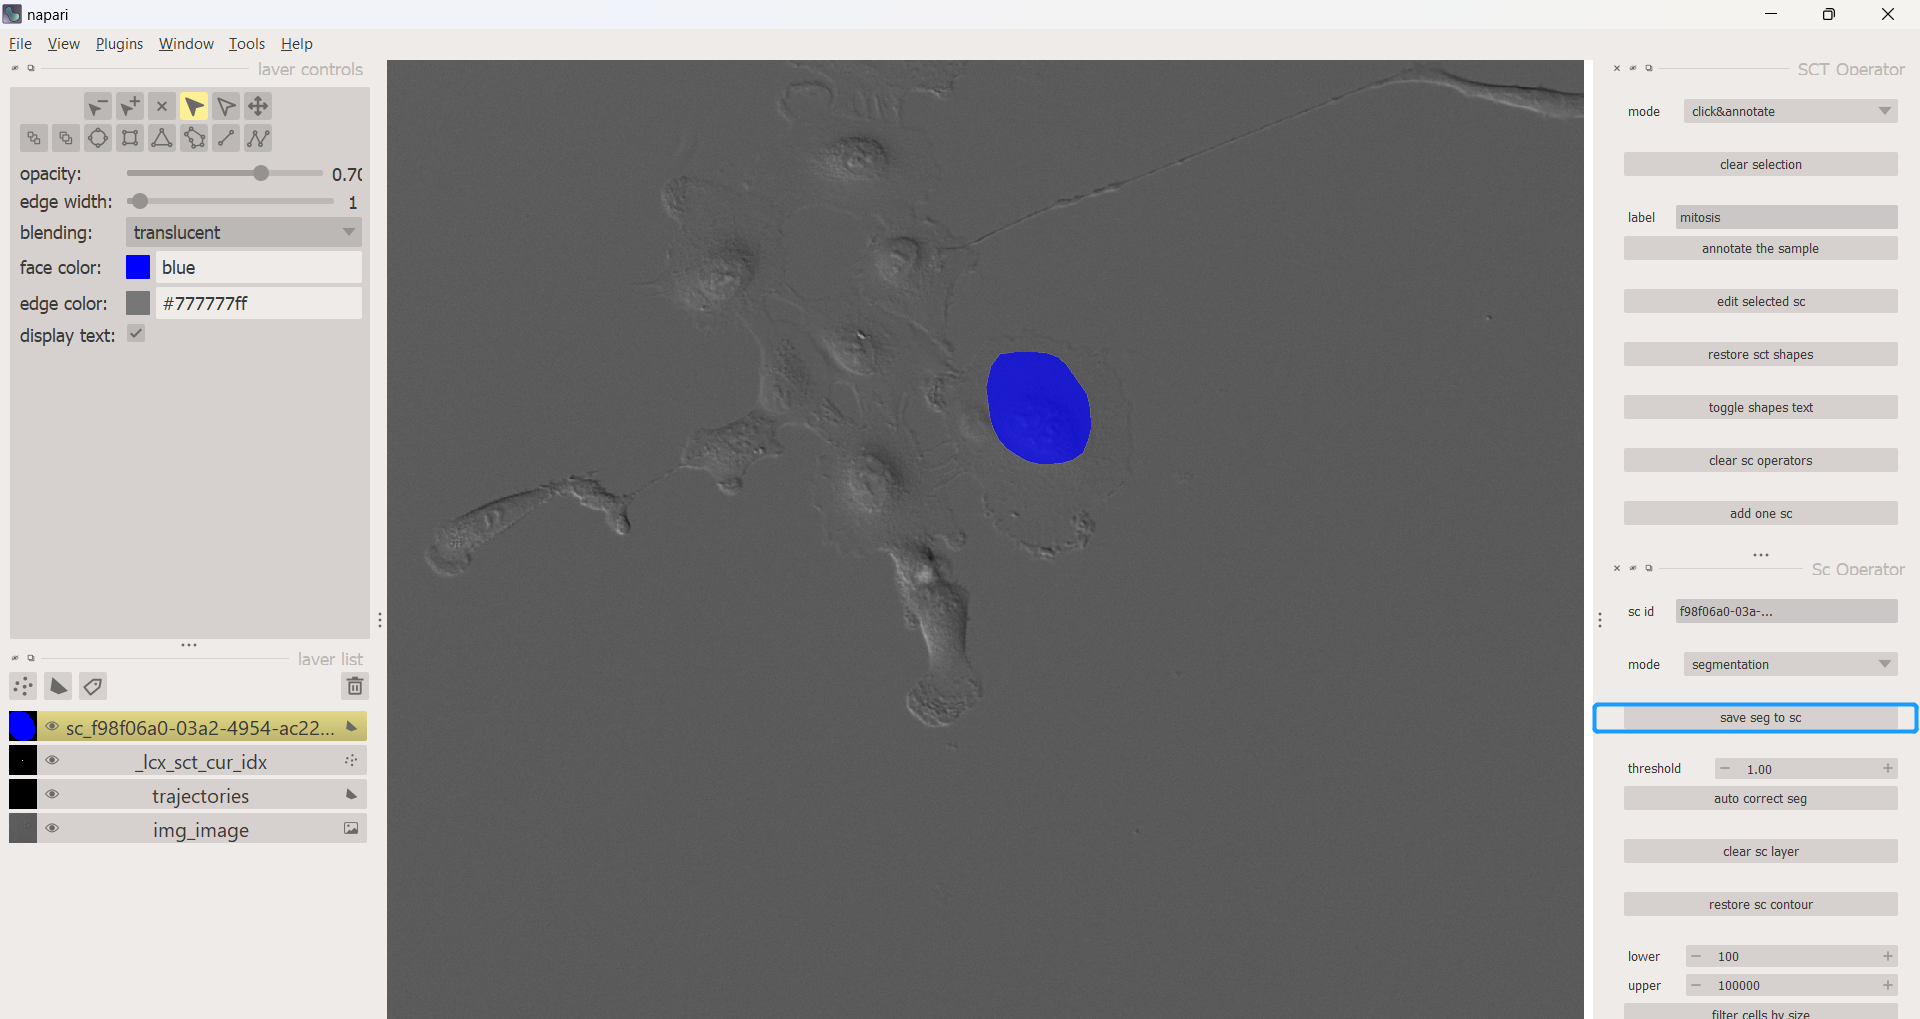

In [23]:
sct_operator.traj_collection.get_all_scs()

[SingleCellStatic(id=f98f06a0-03a2-4954-ac22-1fc280af4650, timeframe=0, bbox=[ 658 1353  789 1476])]

current shape layer shape properties:  Event
setting face color of selected shape...
<selection complete>
current shape layer shape properties:  Event
shape already selected, please select another shape


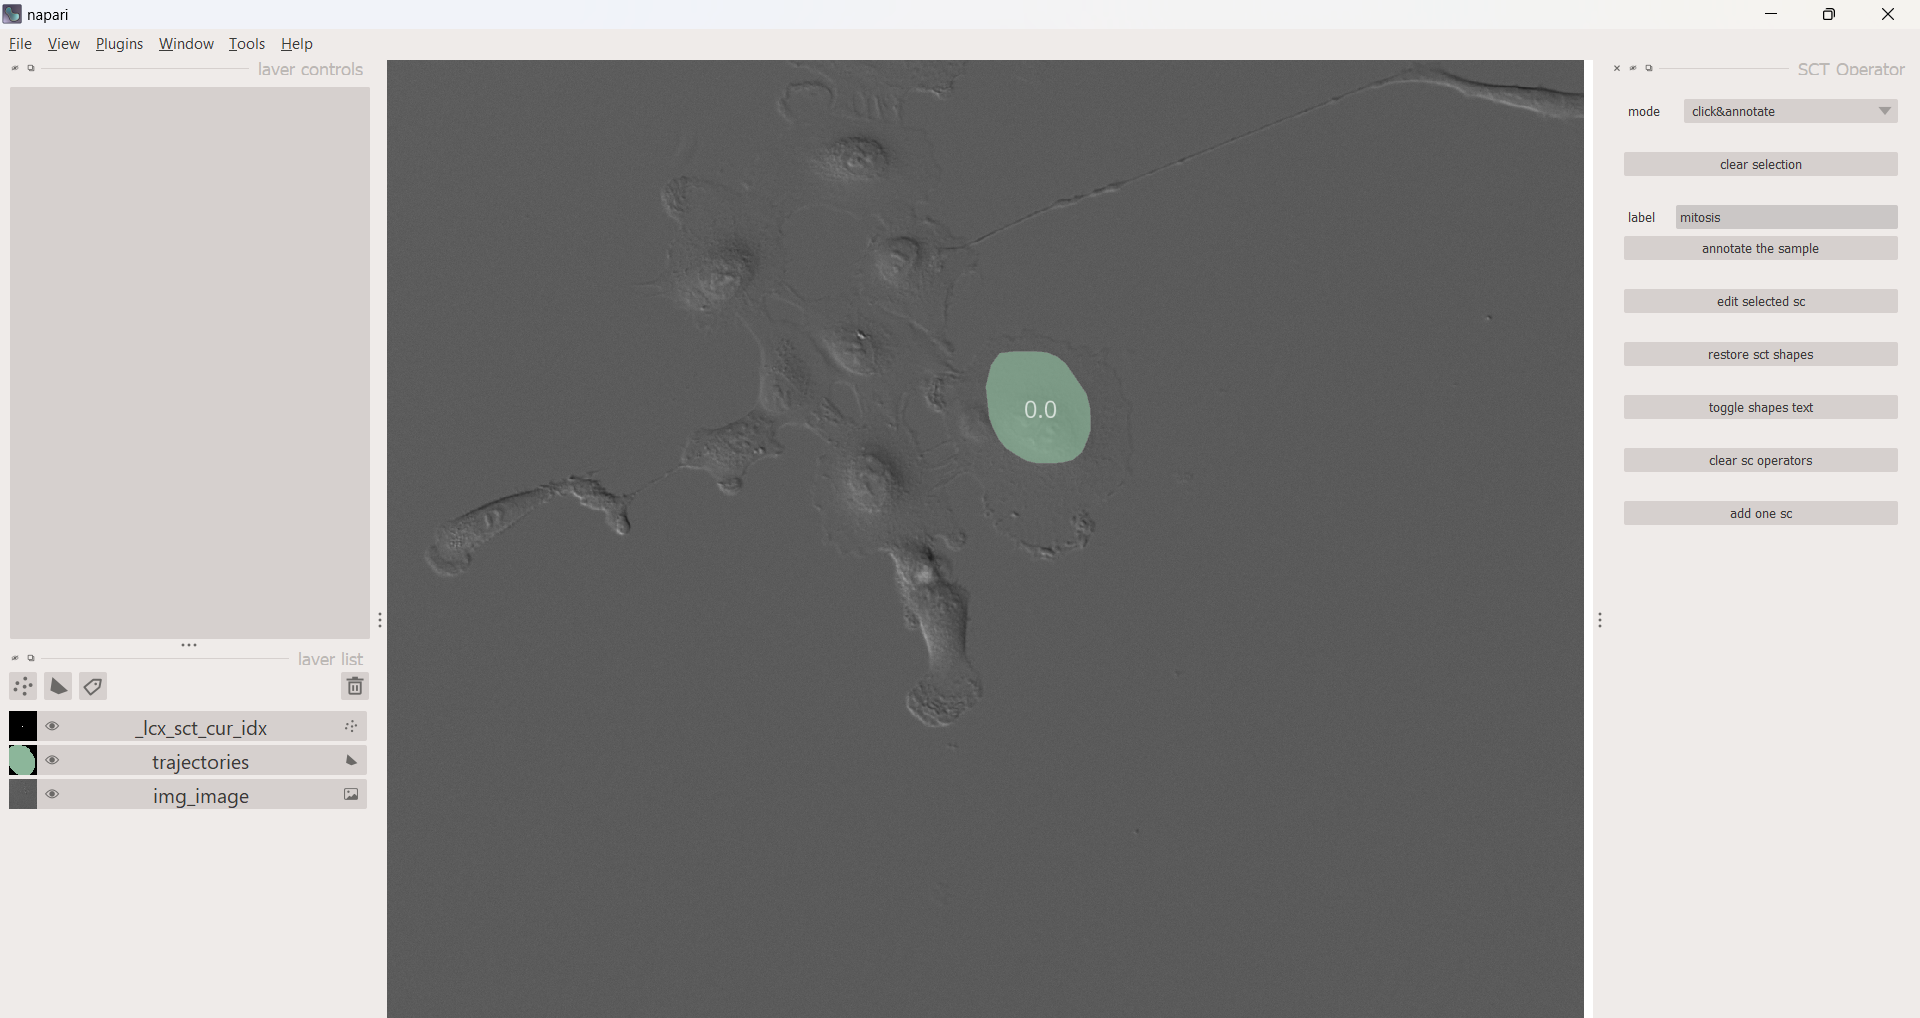
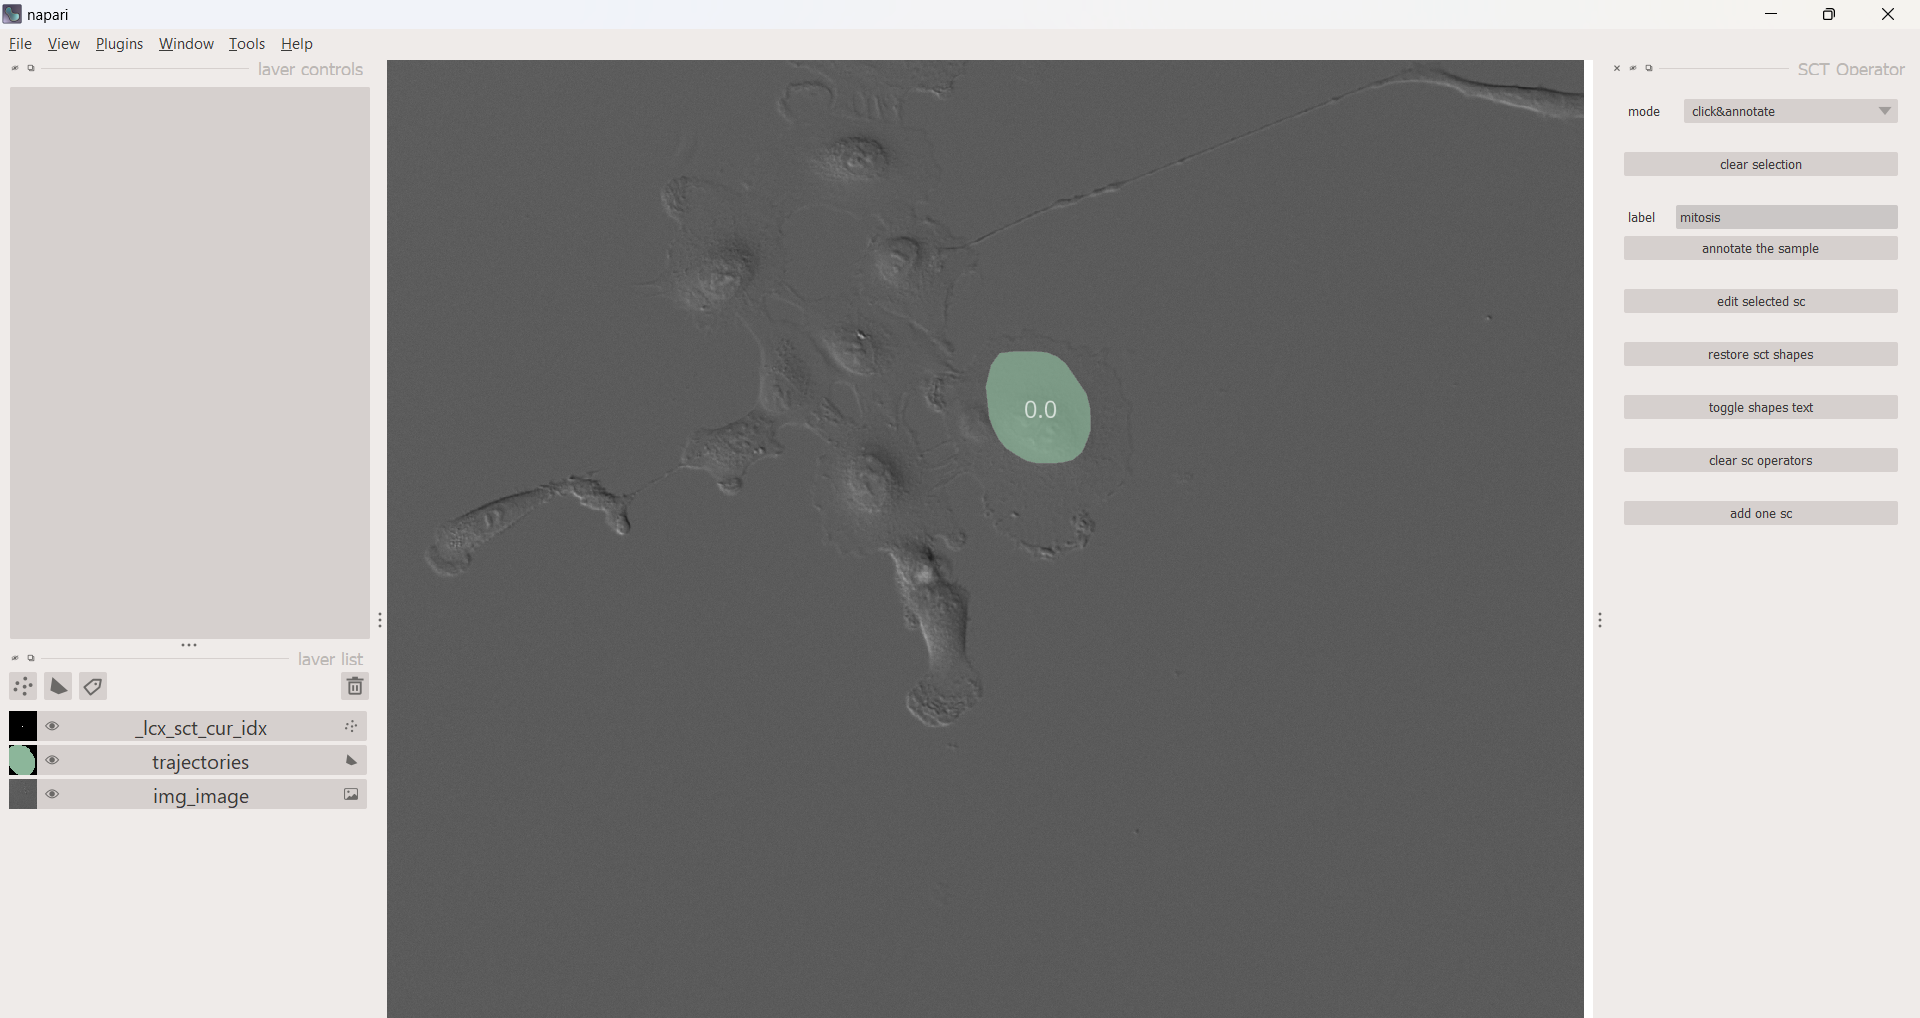

We check annotated mitosis samples

In [25]:
sct_operator.annotate_click_samples

{'mitosis': [{'sample': [SingleCellStatic(id=f98f06a0-03a2-4954-ac22-1fc280af4650, timeframe=0, bbox=[ 658 1353  789 1476])],
   'sample_id': UUID('842383ef-68fb-4c01-be24-5677ed42b608')}]}

You now select all cell masks in one mitosis process and then click `annotate the sample`: 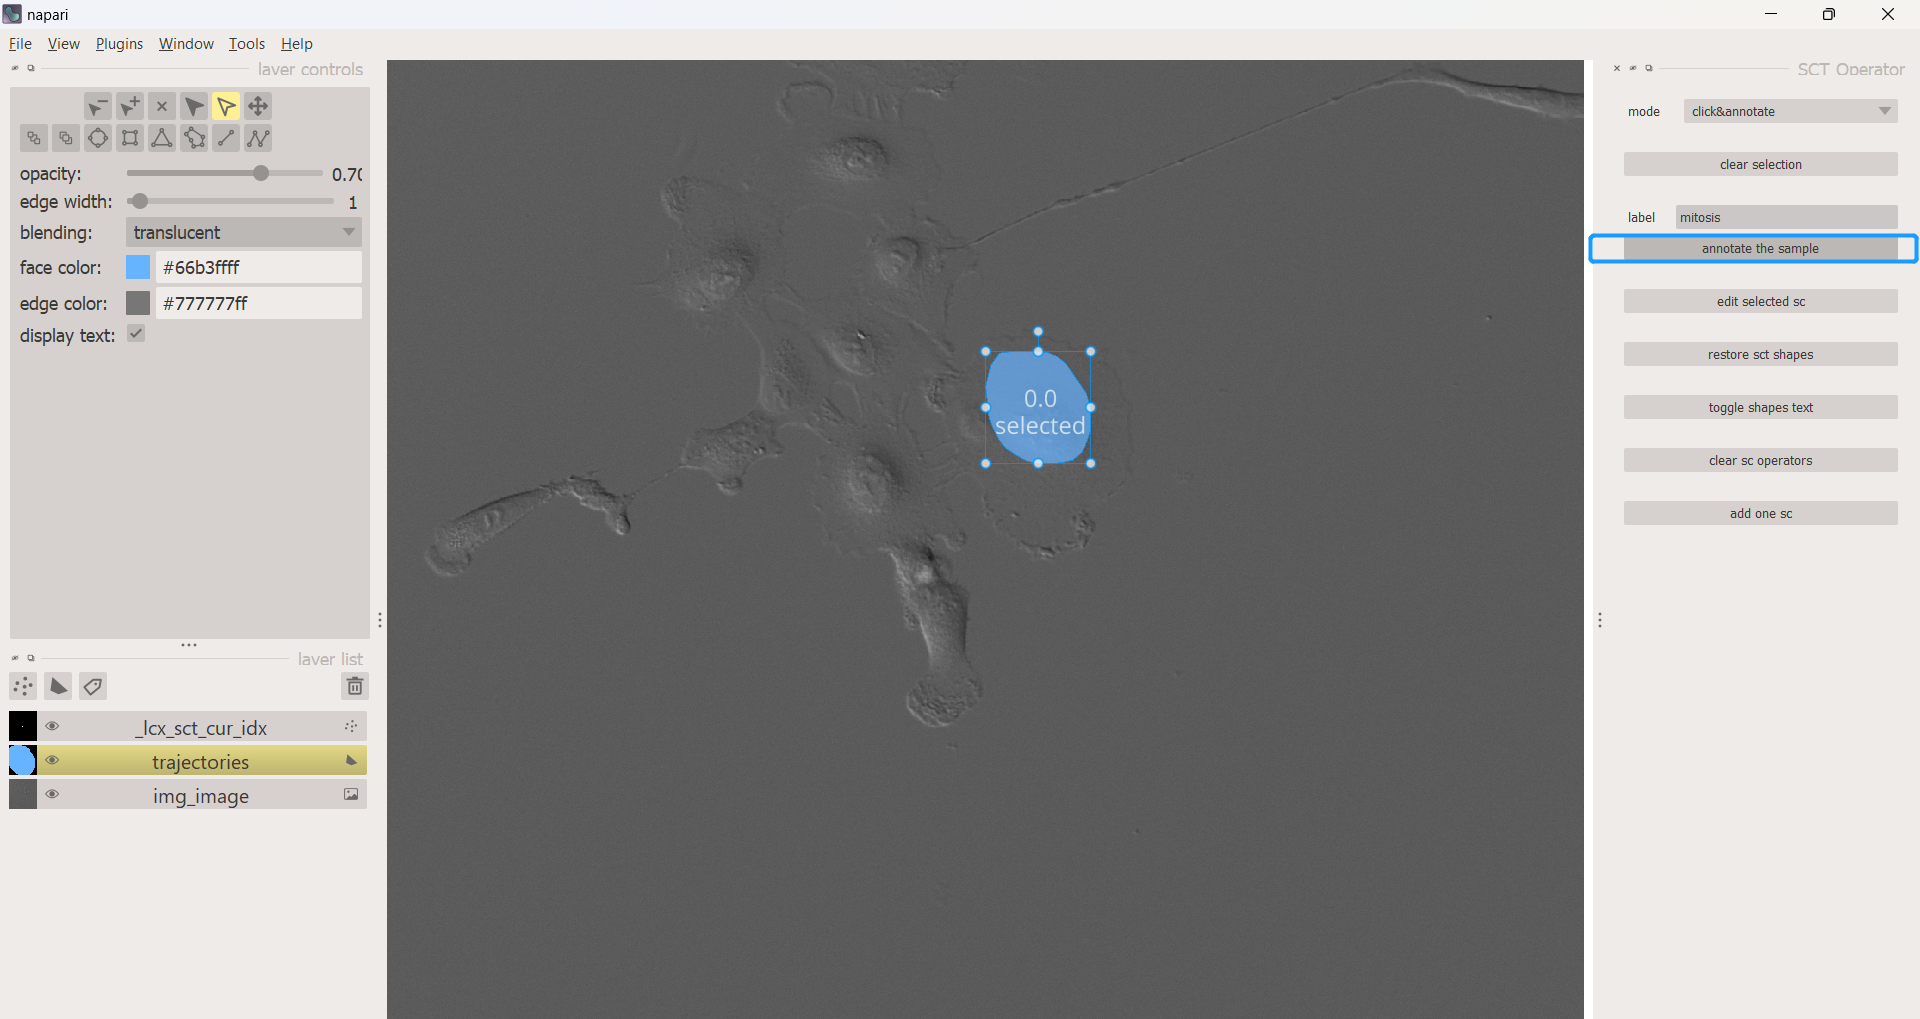

We then extract and print the number of annotated cells.

In [26]:
print(len(sct_operator.original_face_colors))
for key in sct_operator.shape_layer.properties.keys():
    print("property:", key + ",", "len:", len(sct_operator.shape_layer.properties[key]))
print("[sct operator] original scs len", len(sct_operator.original_scs))
print("[sct operator] actual scs len", len(sct_operator.get_all_scs()))

1
property: track_id, len: 1
property: sc, len: 1
property: status, len: 1
[sct operator] original scs len 1
[sct operator] actual scs len 1


### Storing and processing annotations
Once satisfied with the annotations, you can store them for later use or further processing:

In [14]:
# Optionally save the single cell annotations to a JSON file
# Note: sct_operator already saves single cell objects when writing samples, so this step might be optional.
# SingleCellStatic.write_single_cells_json(single_cells=single_cells, path="./datasets/test_scs_EBSS_starvation/XY1/corrected_scs.json", \
#                                          dataset_dir="./datasets/test_scs_EBSS_starvation/XY1/datasets")

We show the number of mitosis samples you annotated. For other labels, you may change the key below (mitosis -> label you customized)

In [27]:
len(sct_operator.annotate_click_samples["mitosis"])

1

We programmatically delete an unwanted sample (e.g. the first one)

In [ ]:
# idx = 0
# label_info_key = "_annotation_label_info"
# for sc in sct_operator.annotate_click_samples["mitosis"][idx]:
#     sc.meta[label_info_key] = {}
# sct_operator.annotate_click_samples["mitosis"].pop(idx)

In [19]:
!mkdir "./datasets/XY1/"

We save the annotations to json files.

In [28]:
sample_out_dir = "./datasets/XY1/annotations"
sample_dataset_dir="./datasets/XY1/datasets"
res_paths = sct_operator.save_annotations(sample_out_dir=sample_out_dir, sample_dataset_dir=sample_dataset_dir)

<saving annotations>
|-----> saving scs
<saving annotations complete>


Annotation files saved path:

In [29]:
res_paths[0].as_posix()

'datasets/XY1/annotations/mitosis/sample_842383ef-68fb-4c01-be24-5677ed42b608.json'